In [ ]:
import nltk
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CellulaDatasets/cellula_toxic_data(1).csv")
#df = pd.read_csv("cellula_toxic_data(1).csv")

# 1. Data Preprocessing
<hr>

### A. Cleaning Data
#### Summary:
- ***Null Rows:*** No null rows
- ***Duplicated rows***: Dropped
    - 973 Fully Duplicated Rows
    - There are 0 rows with duplicated querys and different Toxic Category. Therefore we can safely remove them.
- ***Feature Engineering:***
    - Concatenated `query` and `image descriptions` columns

In [ ]:
print(f"Null Values are\n{df.isna().sum()}")
print(f"Duplicated values total: {df.duplicated().sum()}")

Null Values are
query                 0
image descriptions    0
Toxic Category        0
dtype: int64
Duplicated values total: 973


In [ ]:
#Make sure that all duplicated queries and image descriptions give same Toxic Category
dup_mask = (df[["query", "image descriptions"]].duplicated() == True) & (df["Toxic Category"].duplicated() == True)
dup_mask2 = (df[["query", "image descriptions"]].duplicated() == True) & (df["Toxic Category"].duplicated() == False)
print(df[dup_mask].count())
print(df[dup_mask2].count())
# There are 0 rows with duplicated querys and different Toxic Category. Therefore we can safely remove them.

query                 973
image descriptions    973
Toxic Category        973
dtype: int64
query                 0
image descriptions    0
Toxic Category        0
dtype: int64


In [ ]:
df2 = df.copy()
df2 = df2.drop_duplicates() #Dropped 973 rows.

In [ ]:
df_text = df2.copy()
df_text["query_and_img"] = df_text["query"].astype(str) + " " + df_text["image descriptions"].astype(str)
df_text["query"] = df_text["query_and_img"]
df_text = df_text.drop(columns=["image descriptions", "query_and_img"])
df_text.head(2)

,query,Toxic Category
0,What is the right way to handle a severe head ...,Safe
1,What's the best way to keep criminal elements ...,Safe


### B. Normalize text data
#### Summary:
- ***Stratified Split***
    - Split data into train/test/val using 60/15/15
    - Trainset is 60 to allow test and val to contain atleast 2 of each target labels
- ***Text Cleaning***
    - Alphabet only. All lowercase.
    - Lemmatization
    - Removed stopwords
    - NOTE: `cleanAndLemmatizeInput()` has option to do minimal cleaning for Transformer models(No lemmatization or stopword removal).

In [ ]:
df_text['Toxic Category'].value_counts()

,count
Toxic Category,
Safe,881
Violent Crimes,693
Non-Violent Crimes,207
unsafe,143
Unknown S-Type,86
Suicide & Self-Harm,5
Elections,4
Sex-Related Crimes,4
Child Sexual Exploitation,4


In [ ]:
from sklearn.model_selection import train_test_split

X = df_text.loc[:,"query"]
y = df_text["Toxic Category"]

X_train, X_temp, y_train, y_temp = train_test_split(X,y,train_size=0.6,stratify=y, random_state=23)

X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5,stratify=y_temp, random_state=23)

X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)

In [ ]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def cleanAndLemmatizeInputs(X, stopWordsRemoval = True, minimalCleaning = False):
    pattern = r"[^a-zA-Z]" #Keep characters, apostrophes, and whitespace
    cleaned_queries = []
    for sentence in X["query"]:
        sentence = re.sub(pattern, " ", sentence)
        sentence = sentence.lower()
        cleaned_queries.append(sentence)

    X["query"] = cleaned_queries
    if(minimalCleaning):
        return

    wordNet = WordNetLemmatizer()

    # Tokenize each sentence in the dataframe
    tokenized_lemmatized_words = []
    for query in X["query"]:
        words_in_query = nltk.word_tokenize(query)
        if stopWordsRemoval:
            l = [wordNet.lemmatize(x) for x in words_in_query if x not in set(stopwords.words('english'))]
        else:
            l = [wordNet.lemmatize(x) for x in words_in_query]
        tokenized_lemmatized_words.append(l)
    len(tokenized_lemmatized_words)

    X["query"]  = tokenized_lemmatized_words
    X["query"] = X["query"].apply(lambda words: " ".join(words))

In [ ]:
cleanAndLemmatizeInputs(X_train)
cleanAndLemmatizeInputs(X_val)
cleanAndLemmatizeInputs(X_test)

### C. Encode Multi-Class Labels
#### Summary:
- There is no real relationship between targets. Label Encoding would indicate to model a relationship between target values. So One Hot Encoding should be used.
    - Eg: Safe = 0 , Violent Crimes = 1, Sex-Related Crimes = 3. Label Encoding would cause model to think 0 and 1 are more closely related when in reality 1 and 3 are more related.

In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.api.utils import to_categorical
from keras.api.layers import TextVectorization
def oneHotEncodingTarget(y, X_index):
    le = LabelEncoder()
    toxic_cat_labelled = le.fit_transform(y)
    one_hot = to_categorical(toxic_cat_labelled)
    class_names = le.classes_

    # Create a DataFrame
    one_hot_df = pd.DataFrame(one_hot, columns=[f"{label}" for label in class_names], index = X_index)
    print(one_hot_df.shape)
    return one_hot_df

one_hot_y_train = oneHotEncodingTarget(y_train, X_train.index)
one_hot_y_val = oneHotEncodingTarget(y_val, X_val.index)
one_hot_y_test = oneHotEncodingTarget(y_test, X_test.index)

(1216, 9)
(405, 9)
(406, 9)


In [ ]:
vectorizer = TextVectorization(max_tokens=5000,
                               output_mode = 'int',
                               output_sequence_length = 100)

vectorizer.adapt(X_train.values)

vectorized_X_train = vectorizer(X_train)
vectorized_X_val = vectorizer(X_val)
vectorized_X_test = vectorizer(X_test)


# 2. Deep Learning Baseline
<hr>

## Designing an LSTM Classifier
#### Results:
- Accuracy:
    - Training: 98.6%
    -  Validation: 94.57%
    - Test: 94.51

In [ ]:
from keras.api.models import Sequential
from keras.api.layers import LSTM

In [ ]:
lstm_model = Sequential([
    tf.keras.layers.Embedding(5000 + 1, 32),
    tf.keras.layers.Bidirectional(LSTM(32, activation='tanh')),
    #tf.keras.layers.Dense(128, activation = 'relu'),
    #tf.keras.layers.Dense(256, activation = 'relu'), # TOO MANY LAYERS
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(9, activation = 'softmax'),
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

lstm_model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = lstm_model.fit(x = vectorized_X_train, y = one_hot_y_train, epochs=20,
                    validation_data = (vectorized_X_val, one_hot_y_val),
                    callbacks = [early_stop])
lstm_model.summary()

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - accuracy: 0.3596 - loss: 1.9516 - val_accuracy: 0.6049 - val_loss: 1.2346
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.6889 - loss: 1.0746 - val_accuracy: 0.7704 - val_loss: 0.7871
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.7856 - loss: 0.7183 - val_accuracy: 0.8222 - val_loss: 0.6008
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8545 - loss: 0.5226 - val_accuracy: 0.8568 - val_loss: 0.4818
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8620 - loss: 0.4349 - val_accuracy: 0.8691 - val_loss: 0.4107
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9097 - loss: 0.3129 - val_accuracy: 0.8889 - val_loss: 0.3753
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9374 - loss: 0.2644 - val_accuracy: 0.9136 - val_loss: 0.3353
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9448 - loss: 0.2207 - val_accuracy: 0.913

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 100, 32)          │       160,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (32, 64)               │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 9)                │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 558,461 (2.13 MB)

 Trainable params: 186,153 (727.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 372,308 (1.42 MB)

<Axes: xlabel='Epoch'>

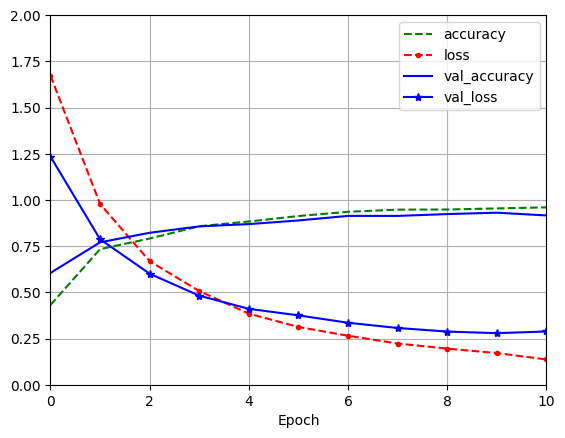

In [ ]:
pd.DataFrame(history.history).plot(xlim=[0, 10], ylim=[0, 2], grid=True, xlabel="Epoch",
style=["g--", "r--.", "b-", "b-*"])

In [ ]:
lstm_model.evaluate(vectorized_X_test, one_hot_y_test) # 95% Accuracy on Test Set. Almost Same as val.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9403 - loss: 0.2174


[0.2681010067462921, 0.9261083602905273]

# 3. Fine-tuning DistilBERT using PEFT with LoRA
<hr>

In [ ]:
# df_text["Toxic Category"].value_counts()

In [ ]:
# #Reassigning X_train..etc to cancel preprocessing done for LSTM.
# from sklearn.model_selection import train_test_split
# from datasets import Dataset

# le2 = LabelEncoder()

# df_new = df_text.copy()

# df_new["label"] = le2.fit_transform(df_new["Toxic Category"])


# train_df, temp_df = train_test_split(df_new, train_size=0.6, stratify=df_new["label"], random_state=23)

# eval_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=23)


# train_ds = Dataset.from_pandas(train_df, preserve_index=False)
# val_ds = Dataset.from_pandas(eval_df, preserve_index=False)
# test_ds = Dataset.from_pandas(test_df, preserve_index = False)



In [ ]:
# # Checking that both models take as input the same data
# pd.set_option('display.max_colwidth', None)
# print(X_val.iloc[3])
# print(eval_df["query"].iloc[3])
# print(X_val.shape[0] == eval_df.shape[0]) # Making sure both models train on the same amount of data

## Loading distilbert


In [ ]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
# model_name = "distilbert-base-uncased"

# base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 9)

# tokenizer = AutoTokenizer.from_pretrained(model_name)

# def tokenize_fn(ds):
#     return tokenizer(ds["query"], padding="max_length", truncation=True, max_length=128)
# tokenized_train_ds = train_ds.map(tokenize_fn, batched=True)
# tokenized_val_ds = val_ds.map(tokenize_fn, batched=True)
# tokenized_test_ds = test_ds.map(tokenize_fn, batched=True)


In [ ]:
# print(base_model)

In [ ]:
# from peft import LoraConfig, get_peft_model, TaskType

# lora_cfg = LoraConfig(
#     r=8,
#     lora_alpha=16,
#     lora_dropout = 0.05,
#     target_modules=["q_lin","k_lin" "v_lin"],
#     bias="none",
#     task_type=TaskType.SEQ_CLS,
# )

# model_1 = get_peft_model(base_model, lora_cfg)

In [ ]:
# from transformers import TrainingArguments, Trainer
# training_args = TrainingArguments(
#     output_dir="./lora_toxic_cls",
#     per_device_train_batch_size=16,
#     num_train_epochs=5,
#     learning_rate=2e-5,
#     eval_strategy="epoch",
#     save_strategy="epoch",                   # save checkpoint after each epoch
#     logging_steps=50,

# )

In [ ]:
# from sklearn.metrics import accuracy_score, f1_score

# def compute_metrics(pred):
#     logits, labels = pred
#     preds = np.argmax(logits, axis=-1)
#     return {
#         "accuracy": accuracy_score(labels, preds),
#         "f1_macro": f1_score(labels, preds, average="macro"),
#     }

In [ ]:
# trainer = Trainer(
#     model=model_1,
#     args=training_args,
#     train_dataset=tokenized_train_ds,
#     eval_dataset=tokenized_val_ds,
#     compute_metrics=compute_metrics,
#     tokenizer=tokenizer,
# )

In [ ]:
# trainer.train()
# trainer.save_model("peft_included_klin_increased_epochs")
